In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json
import re

Pull in the processed inventory

In [2]:
ra = "GCOOS"

#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).


ra_clean = re.sub(r'[0-9]', '', ra) # remove number from RA 

df = pd.read_excel('2023/data/processed/%s.xlsx' % ra_clean.upper(), dtype=str)
df

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,ioos:station:CBI:042,NaN,042: Nueces Delta 2: Nueces Delta 2,https://lighthouse.tamucc.edu/overview/042,27.8888,-97.5696,fixed,>5 yr,Y,Unknown,N,The Coastal Bend Bays & Estuaries Program,academic,"Conrad Blutcher Institute, TAMUCC",Niall Durham (niall.durham@tamucc.edu),"sea_water_practical_salinity, sea_water_temper...",NaN
1,ioos:station:CBI:069,NaN,069: Nueces Delta Weather Station,https://lighthouse.tamucc.edu/overview/069,27.8976,-97.6165,fixed,>5 yr,Y,Unknown,N,Guadalupe Blanco River Authority (GBRA),academic,"Conrad Blutcher Institute, TAMUCC",Niall Durham (niall.durham@tamucc.edu),"air_pressure, air_temperature, relative_humidi...",NaN
2,ioos:station:CBI:072,NaN,"072: SALT01 (Nueces Bay, Texas): SALT01 (Nuece...",https://lighthouse.tamucc.edu/overview/072,27.839194,-97.443972,fixed,>5 yr,Y,Unknown,N,City of Corpus Christi Salinity Monitoring,academic,"Conrad Blutcher Institute, TAMUCC",Niall Durham (niall.durham@tamucc.edu),"mass_concentration_of_oxygen_in_sea_water, sea...",NaN
3,ioos:station:CBI:074,NaN,"074: SALT03 (Nueces Bay, Texas): SALT03 (Nuece...",https://lighthouse.tamucc.edu/overview/074,27.85155,-97.48203,fixed,>5 yr,Y,Unknown,N,City of Corpus Christi Salinity Monitoring,academic,"Conrad Blutcher Institute, TAMUCC",Niall Durham (niall.durham@tamucc.edu),"mass_concentration_of_oxygen_in_sea_water, sea...",NaN
4,ioos:station:CBI:076,NaN,"076: SALT05 (Nueces River, Texas): SALT05 (Nue...",https://lighthouse.tamucc.edu/overview/076,27.89183,-97.61045,fixed,>5 yr,Y,Unknown,N,City of Corpus Christi Salinity Monitoring,academic,"Conrad Blutcher Institute, TAMUCC",Niall Durham (niall.durham@tamucc.edu),"sea_water_practical_salinity, sea_water_temper...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,ioos:station:GCOOS:42G03,42G03,42G03 - Anchor - Green Canyon 763,https://www.chevron.com/,27.2268,-91.1906,Mobile Offshore Drilling Unit,<5 yr,Y,Unknown,N,Chevron,industry,Chevron,GCOOS (data@gcoos.org),"sea_water_speed, upward_sea_water_velocity, di...",NaN
265,ioos:station:GCOOS:42G05,42G05,42G05 - BP Atlantis - Green Canyon 787,https://www.bp.com/,27.1978,-89.9909,Moored Buoy,<5 yr,Y,Unknown,N,BP Inc,industry,BP Inc,GCOOS (data@gcoos.org),"sea_water_speed, upward_sea_water_velocity, di...",NaN
266,ioos:station:PMEL:Cheeca_Rocks,NaN,Cheeca - Cheeca Rocks Mooring,https://www.pmel.noaa.gov/co2/story/Cheeca+Rocks,24.9,-80.62,Moored Buoy,>5 yr,Y,Unknown,N,"Pacific Marine Environmental Laboratory, NOAA",gov_state,"Pacific Marine Environmental Laboratory, NOAA",GCOOS (data@gcoos.org),"air_temperature,mass_concentration_of_chloroph...",NaN
267,ioos:station:PMEL:Coastal_LA,NaN,CoastalLA - Coastal Louisiana buoy,https://www.pmel.noaa.gov/co2/story/Coastal+LA,28.9,-90.5,Moored Buoy,>5 yr,Y,Unknown,N,"Pacific Marine Environmental Laboratory, NOAA",gov_state,"Pacific Marine Environmental Laboratory, NOAA",GCOOS (data@gcoos.org),"air_temperature,mass_concentration_of_chloroph...",NaN


Make a plot of all points and color based on ERDDAP available or not.

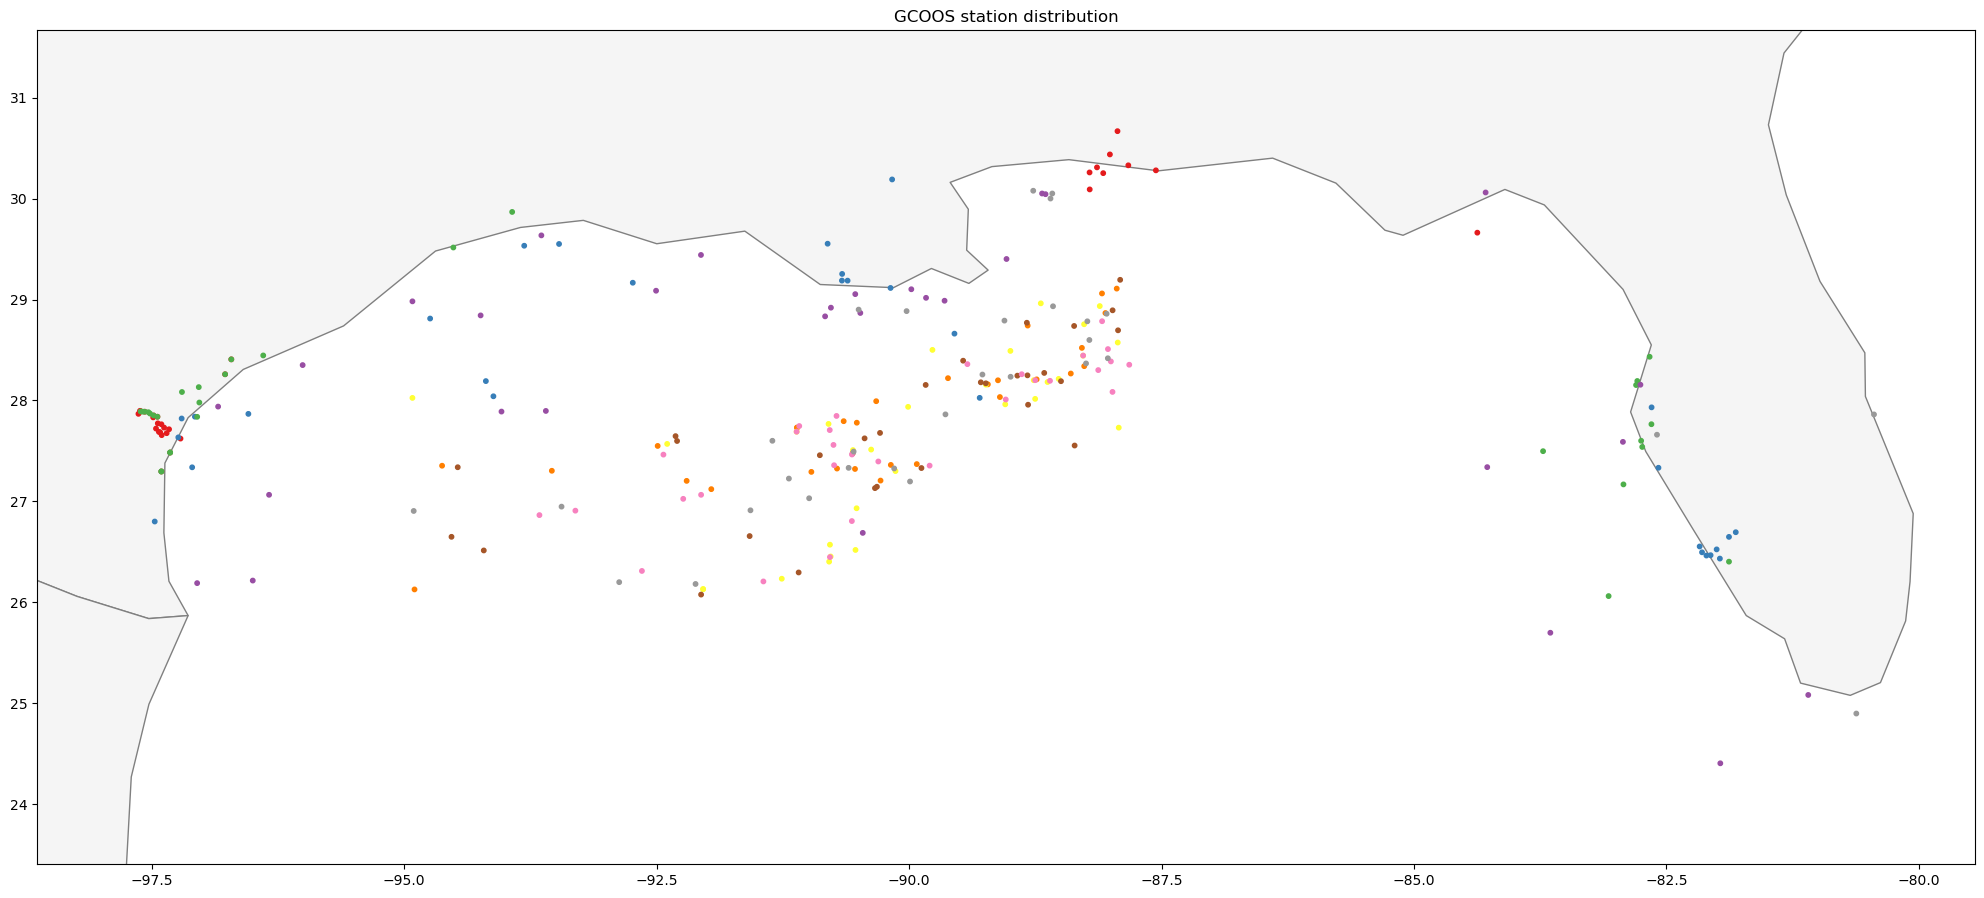

In [3]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         #column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [4]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore()#'erddap_avail',cmap = 'Set1')


In [5]:
while True:
    # some code here
    if input('Do You Want To Continue? ') != 'y':
        break

KeyboardInterrupt: Interrupted by user

Configure the ERDDAP to search

In [ ]:
with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

Search the ERDDAP server for a single station of interest - more of a test

In [ ]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [ ]:
# df_wf = df[df['Station ID'] == 'Jug_Bay']

# # for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
# search_for = df_wf['Station ID'].to_string()

# search_url = e.get_search_url(search_for=search_for, response="csv")

# try:
#     resp = pd.read_csv(search_url)
#     print(resp['Station ID'])
# except:
#     pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [ ]:
not_found = []
found = dict()

exclude = ' -gliders'

#search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

# GLOS
search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']
# SCCOOS
#search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']

for search1 in df[search_order[0]].astype(str):
    
    if search1 == "nan":
        print("punting with %s = nan\n" % search_order[0])
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

Print the stations that we couldn't find.

In [ ]:
len(not_found)

In [ ]:
len(found)

Show me the record that has NaN for the first search element.

In [ ]:
df.loc[df[search_order[0]].isna()]

Now show me the stations, with identifiers, that we couldn't find.

In [ ]:
df[df[search_order[0]].isin(not_found)]

Print out all the dataset IDs for the datasets that matched our criteria.

In [ ]:
found

Check if each found dataset has coverage for specified CY

In [ ]:
valid_datasets = []

cy = '2023'

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "{}-01-01".format(cy)
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "{}-01-01".format(cy)
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

no_cov_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for {}:\n{}'.format(cy,no_cov_datasets))

Show me the inventory metadata about the invalid stations:

In [ ]:
bad_stations = df.loc[(df[search_order[0]].isin(no_cov_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

df.loc[df['erddap_not_avail']]

Invert the `erddap_not_avail` column and drop it.

In [ ]:
df['erddap_avail'] = ~df['erddap_not_avail']

df.drop(columns='erddap_not_avail', inplace=True)

df

Make a plot of all points and color based on ERDDAP available or not.

In [ ]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         #column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [ ]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore('erddap_avail',cmap = 'Set1')


## Show me some bad coordinates

_if there are any_

In [ ]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

In [ ]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

# Show me the stations where ERDDAP doesn't exist or provide a valid response.

Reasons:
* Station not found on RA erddap
* dataset found but no data for this CY.

In [ ]:
gdf_final.loc[~gdf_final['erddap_avail']]

# Do some checking against the IOOS catalog

only for datasets that we couldn't find in ERDDAP (per above)

In [ ]:
from ckanapi import RemoteCKAN
import xarray as xr

problem_datasets = []

ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

gdf_ckan = gdf_final.loc[~gdf_final['erddap_avail']]


for station in gdf_ckan['Station ID'].dropna():

    RA = gdf_ckan.loc[gdf_ckan['Station ID']==station,'RA'].tolist()[0]
    
    print('Station "{}" + RA "{}"'.format(station.lower(), RA.lower()))
    
    # build RA tag query
    fq = '+organization:{}'.format(RA.lower())

    # build free text query
    q = "\""+station.lower()+"\""+" -glider"

    query = ioos_catalog.address + '/dataset/?' + 'q=' + q + '&organization=' + RA.lower()
    
    print('Query: {}'.format(query.replace(" ","%20")))

    datasets = ioos_catalog.action.package_search(q=q, fq=fq)

    

    if datasets['count'] > 0:
        print('\tfound {} dataset(s):'.format(datasets['count']))
        
        for dataset in datasets['results']:
            print('\t',dataset['title'])
            
            
            if dataset['resources']:
                print('\t',dataset['resources'][0]['url'])

                start_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-begin")['value']
                end_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-end")['value']

                print('\t','Coverage Meta:\n\t\t', start_date,' - ',end_date,'\n')

                if 'thredds' in dataset['resources'][0]['url']:
                    ds = xr.open_dataset(dataset['resources'][0]['url'])

                    time_max = ds.time.max().values

                    time_min = ds.time.min().values


                    print('\tCoverage Data:\n\t\t', time_min,' - ',time_max, '\n')

                    if pd.to_datetime(end_date) < pd.to_datetime(time_max, utc=True):
                        test_date = pd.to_datetime(time_max, utc=True)

                else:
                    test_date = pd.to_datetime(end_date, utc=True)

                if test_date > pd.to_datetime('{}-01-01'.format(cy), utc=True):
                    print('\t{} is valid.'.format(station))
                    break
                else:
                    print('\t{} is not valid.'.format(station))

                    problem_datasets.append(station)
            
            else:
                print('\t{} missing additional metadata'.format(station))
                problem_datasets.append(station)
    else:
        print("\tNo datasets found!")
        problem_datasets.append(station)

Check the datasets that didn't have coverage in ERDDAP or through IOOS catalog and see if they are **Currently Operational?**

In [ ]:
gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]

Print out the available metadata from the IOOS Catalog for the last dataset.

In [ ]:
dataset

In [ ]:
# GLOS special case as they provide ERDDAP ID

# for dataset in gdf_final.loc[(~gdf_final['erddap_avail'] & ~gdf_final['Dataset (ERDDAP) ID'].isna()),'Dataset (ERDDAP) ID'].tolist():
#     print(dataset)
#     e.dataset_id = dataset
    
#     e.constraints = {
#                  "time>=": "{}-01-01".format(cy)
#             }
        
#     e.variables = ['time']
    
#     try:
        
#         df_data = e.to_pandas(parse_dates=True)
        
#         string = '\tDate range: {} - {}'.format(df_data.min()[0],df_data.max()[0])
        
#         print(string)
        
#         if pd.to_datetime(df_data.max()[0], utc=True) > pd.to_datetime('{}-01-01'.format(cy), utc=True):
            
#             datasetid = gdf_final.loc[gdf_final['Dataset (ERDDAP) ID']==dataset,'Station ID'].tolist()[0]
            
#             problem_datasets.remove(datasetid)
        
#     except:
#         print('\tNo valid data')

In [ ]:
#gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]